In [21]:
# Import used for the band selection framework
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.transform import resize   
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import mahotas
from sklearn.preprocessing import StandardScaler 
import sys, os; sys.path.insert(0, os.path.abspath('..'))   
from dataset import *
from util import *
from tqdm import tqdm
from pathlib import Path


Proccesing images: 100%|██████████| 176/176 [12:21<00:00,  4.21s/it]



=== GLOBAL segment distribution (all images) ===
class 0: 4340 segments  (32.88%)
class 1: 705 segments  (5.34%)
class 2: 7 segments  (0.05%)
class 3: 1425 segments  (10.79%)
class 4: 6724 segments  (50.94%)


UMDA Generations: 100%|██████████| 30/30 [1:01:16<00:00, 122.54s/it]


 Top 30 SVM Band Combinations:
#1: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#2: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#3: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#4: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#5: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#6: Bands [0, 3, 7] → Balanced Accuracy: 0.603
#7: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#8: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#9: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#10: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#11: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#12: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#13: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#14: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#15: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#16: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#17: Bands [0, 3, 6] → Balanced Accuracy: 0.603
#18: Bands [0, 3, 5] → Balanced Accuracy: 0.603
#19: Bands [0, 3, 5] → Balanced Accuracy: 0.603
#20: Bands [0, 3, 5] → Balanced Accuracy: 0.603
#21: Bands [0, 3,

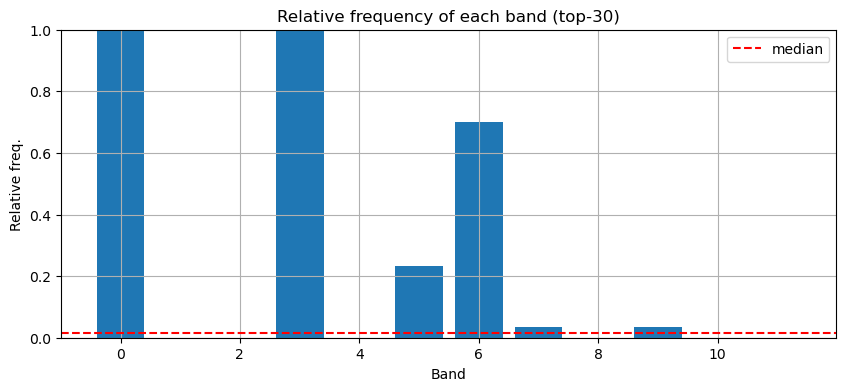

Final Test Balanced Accuracy: 0.4846967652461851


In [22]:
np.random.seed(420)  

def preprocess_image(image, target_shape=(256, 256), n_components=3):
    """
    Fill NaNs, resize bands to `target_shape`, and return top-`n_components` PCA channels + resized image.
    """
    image = np.nan_to_num(image) # Fills nan values 
    small_image = np.stack([
        resize(image[i], target_shape, mode='reflect', anti_aliasing=True)
        for i in range(image.shape[0])
    ]) # resizes the images from to shape 256 x 256 
    reshaped = small_image.reshape(small_image.shape[0], -1).T # flattens spatial dimensions
    pca = PCA(n_components=n_components) # pca object
    pca_components = pca.fit_transform(reshaped) # learns the pca of the image and returns projected data
    pca_image = pca_components.T.reshape(n_components, *target_shape) # reshapes back to (3, 256, 256)
    return pca_image, small_image # pca image and downscaled orginal image for extracting descriptors


def generate_superpixels_slic(pca_image, n_segments = 500, compactness=10, sigma=1):
    """
    Run SLIC superpixels on a 3-channel image and return the segment label map.
    """
    rgb = np.moveaxis(pca_image, 0, -1)  # (3, 256, 256) → (256, 256, 3) to match slic expectation
    return slic(img_as_float(rgb), n_segments=n_segments, compactness=compactness, sigma=sigma)


def filter_segments_by_homogeneity(
    segments,
    mask,
    min_pixels=150,
    min_homogeneity=0.9,
):
    """
    Keep only segments with ≥ `min_pixels` pixels and ≥ `min_homogeneity` purity; return their IDs and pixel indices.
    """
    num_classes = mask.shape[0]
    filtered_segments = []
    segment_info = {}
    label_map = np.argmax(mask, axis=0)
    
    for seg_id in np.unique(segments):
        indices = np.argwhere(segments == seg_id)
        # Discard small segments
        if len(indices) < min_pixels:
            continue

        # Check class purity
        seg_labels = label_map[tuple(indices.T)]
        counts = np.bincount(seg_labels, minlength=num_classes)
        majority_class = np.argmax(counts)
        homogeneity = counts[majority_class] / counts.sum()

        if homogeneity >= min_homogeneity:
            label = majority_class
            filtered_segments.append(seg_id)
            segment_info[seg_id] = (label, indices)

    return filtered_segments, segment_info

def extract_haralick_features(image, segment_info):
    """
    For each segment, compute 13 Haralick descriptors per band and return (features, labels) arrays.
    """
    features = []
    labels = []

    for seg_id, (label, indices) in segment_info.items():
        segment_vector = []

        for b in range(image.shape[0]):  # Loop over each band
            band = image[b]

            # Create a binary mask of the segment
            mask = np.zeros_like(band, dtype=bool)
            mask[tuple(indices.T)] = True
            region = band * mask

            # Crop to bounding box to make it smaller/faster
            minr, minc = indices.min(axis=0)
            maxr, maxc = indices.max(axis=0) + 1
            region_crop = region[minr:maxr, minc:maxc]

            # Normalize to 0–255 and convert to uint8
            region_crop = region_crop.astype(np.float32)
            region_crop -= region_crop.min()
            if region_crop.max() > 0:
                region_crop *= 255.0 / region_crop.max()
            region_crop = region_crop.astype(np.uint8)

            # computes haralick using mahotas library
            try:
                har_features = mahotas.features.haralick(region_crop, distance=1, ignore_zeros=True).mean(axis=0)
            except:
                har_features = np.zeros(13)

            segment_vector.extend(har_features)

        features.append(segment_vector)
        labels.append(label)

    return np.array(features), np.array(labels)



def process_all_images(image_list, mask_list):
    """
    Loop over image/mask pairs and concatenate all segment features and labels.
    """
    X_all, y_all = [], []
    for img, msk in zip(image_list, mask_list):
        X, y = extract_haralick_features(img, msk)
        X_all.append(X)
        y_all.append(y)
    return np.concatenate(X_all), np.concatenate(y_all)


def umda_band_selection(X_train, X_val, y_train, y_val, n_bands=12, population_size=40, n_generations=30, top_k=10):
    """
    Run UMDA over `n_generations` to score band-subsets by SVM val accuracy; return all (subset, score) pairs.
    """
    p = np.full(n_bands, 0.5) # initialze every probability to be 50%
    all_results = []

    for generation in tqdm(range(n_generations), desc="UMDA Generations"): # for each generation
        population = np.random.rand(population_size, n_bands) < p # creates a population
        scores = [] # stores fitness score for each individual 

        for individual in population: # for each indvidual 
            selected_idx = np.where(individual)[0] # array of the selected bands
            if len(selected_idx) == 0: # if no bands selected
                scores.append(0)
                continue

            try:
                # pick out columns for the selected bands
                selected_cols = np.concatenate([[i*13 + j for j in range(13)]
                                                for i in selected_idx])
                X_train_sel = X_train[:, selected_cols]
                X_val_sel   = X_val[:,   selected_cols]
                clf = SVC(kernel='rbf', gamma='scale', class_weight='balanced') # fitness function
                clf.fit(X_train_sel, y_train)
                y_pred = clf.predict(X_val_sel)
                score = balanced_accuracy_score(y_val, y_pred) # gets score from training
            except:
                score = 0
            scores.append(score)
        for ind, score in zip(population, scores):
            all_results.append((ind.astype(int), score)) # stores indiduals as 0/1 vector

        # updates probability based on top k indviduals
        top_idx = np.argsort(scores)[-top_k:]
        top_individuals = population[top_idx]
        new_p = top_individuals.mean(axis=0)
        # avoids probabilites becoming 0 or 1 by clipping
        epsilon = 1.0 / n_bands
        p = 0.1 + 0.8 * np.clip(new_p, epsilon, 1 - epsilon)

    return all_results # returns list of the results from the fitness function 


# ───────────────────────────────────────────────────────────────
def majority_vote_relative(all_results, top_n=30):
    """
    From `all_results`, pick bands whose occurrence among the top `top_n` exceeds the median frequency.
    """
    # Take top-N individuals by score
    elite = sorted(all_results, key=lambda x: x[1], reverse=True)[:top_n]
    elite_mat = np.vstack([ind for ind, _ in elite])      # shape (N, n_bands)

    # Relative frequency per band
    freq_rel = elite_mat.mean(axis=0)          # occurrences / N  → 0..1

    #Select bands above the median relative frequency
    median_val = np.median(freq_rel)
    selected   = np.where(freq_rel >= median_val)[0]       # strict “> median”

    return selected.tolist(), freq_rel

# run the whole pipeline 
def run_pipeline(
    image_list,
    mask_list,
    n_bands=12,
    num_samples=176,
):
    """
    Execute the end-to-end band-selection pipeline and print the final test balanced accuracy.
    X, y = [], []
    """
    for i, (img, msk) in enumerate(tqdm(zip(image_list[:num_samples], mask_list[:num_samples]), total = len(image_list[:num_samples]), desc="Proccesing images")):

        pca_image, downscaled_image = preprocess_image(img)
        segments = generate_superpixels_slic(pca_image)

        mask_downscaled = np.stack([
            resize(msk[c].astype(np.float32), (256, 256), order=0, preserve_range=True, anti_aliasing=False)
            for c in range(msk.shape[0])
        ]).astype(np.uint8)

        _, segment_info = filter_segments_by_homogeneity(
            segments,
            mask_downscaled,
        )

        X_i, y_i = extract_haralick_features(downscaled_image, segment_info)

        X.append(X_i)
        y.append(y_i)

    X = np.concatenate(X)
    y = np.concatenate(y)

    # concatenate already done
    u_all, c_all = np.unique(y, return_counts=True)
    print("\n=== GLOBAL segment distribution (all images) ===")
    for cls, cnt in zip(u_all, c_all):
        print(f"class {cls}: {cnt} segments  ({cnt/len(y):.2%})")


    # 1) Make random splits
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=420
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=0.25,  # 25% of 80% => 20% of total
        stratify=y_trainval,
        random_state=420
    )

   
    scaler = StandardScaler().fit(X_train)
    X_train  = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test= scaler.transform(X_test)

    all_results = umda_band_selection(X_train, X_val, y_train, y_val, n_bands=n_bands)
    
    sorted_results = sorted(all_results, key=lambda x: x[1], reverse=True)
    print("\n Top 30 SVM Band Combinations:")
    for i, (individual, score) in enumerate(sorted_results[:30]):
        selected = np.where(individual == 1)[0]
        print(f"#{i+1}: Bands {selected.tolist()} → Balanced Accuracy: {score:.3f}")
    
    # majority-vote with relative frequency  
    mv_bands, rel_freq = majority_vote_relative(all_results, top_n=30)

    print("\n Best band set:", mv_bands)
    print("  Relative frequencies:", np.round(rel_freq, 3))

    out_json = Path("best_bands.json")
    with out_json.open("w") as f:
        json.dump(mv_bands, f)   

    plt.figure(figsize=(10,4))
    plt.bar(range(n_bands), rel_freq)
    plt.axhline(np.median(rel_freq), color='r', ls='--', label='median')
    plt.ylim(0,1); plt.xlabel("Band"); plt.ylabel("Relative freq.")
    plt.title("Relative frequency of each band (top-30)")
    plt.legend(); plt.grid(True); plt.show()


    # 3) Evaluate final solution on test set
    test_cols = np.concatenate([[b*13 + j for j in range(13)] for b in mv_bands])
    X_test_sel = X_test[:, test_cols]

    clf = SVC(kernel='rbf', gamma='scale', class_weight='balanced')
    clf.fit(X_train[:, test_cols], y_train)  # re-fit on entire training set
    y_pred_test = clf.predict(X_test_sel)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    print("Final Test Balanced Accuracy:", test_score)

    return None


sample_indices = range(176)  

data_path = "../../data"
image_dir = data_path + "/train_images"
mean, std = calculate_overall_mean_std(image_dir)

# Initialize your dataset
dataset = TrainingDataset(data_root=data_path, sample_indices=sample_indices, mean=mean, std=std, include_background=True)

# Extract and convert each image/mask to NumPy
image_list = []
mask_list = []

for i in range(len(dataset)):
    image, mask = dataset[i]  # Returns PyTorch tensors
    image_np = image.numpy()  # Shape: (12, H, W)
    mask_np = mask.numpy()    # Shape: (5, H, W)
    image_list.append(image_np) 
    mask_list.append(mask_np)


run_pipeline(image_list, mask_list, n_bands=12, num_samples=176)  